# Preparing data for national vs. local domains

This file prepares intermediate data files for the national vs. local analysis in national_local_analysis.ipynb.

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import numpy as np

## Preparing data

In [219]:
house_rank_domain = pd.read_csv("/net/lazer/lab-lazer/shared_projects/google_audit_reproduce/intermedidate_files/merged_summary/domain_rank_qry_loc.csv")

In [221]:
loc_rank_counts = house_rank_domain.groupby(['domain', 'qry', 'serp_rank', 'loc_id'], dropna=True, as_index=False)['counts'].sum()

In [222]:
loc_rank_counts[:5]

,domain,qry,serp_rank,loc_id,counts
0,1011now.com,Ben Cline,18.0,"DC-AT LARGE,District of Columbia,United States",1
1,1011now.com,Ben Cline,18.0,"WA-1,Washington,United States",1
2,1011now.com,Ben Cline,18.0,"WA-10,Washington,United States",1
3,1011now.com,Ben Cline,18.0,"WA-2,Washington,United States",1
4,1011now.com,Ben Cline,18.0,"WA-3,Washington,United States",1


In [223]:
loc_rank_counts['counts'].sum()

299573378

In [224]:
qry_loc_list = loc_rank_counts[['qry','loc_id']].drop_duplicates()

In [225]:
# Define a function to parse the address
def get_state(loc_id):
    location_components = loc_id.split(",")
    first_component = location_components[0].split("-")
    return first_component[0]
    
    
def get_district(loc_id):
    location_components = loc_id.split(",")
    first_component = location_components[0].split("-")
    if len(first_component) > 1:
        return first_component[1]
    else:
        return None

def check_home_state(row):
    if row["srch_state"] == row['home_state']:
        return True
    return False

    
def check_home_district(row):
    if row['srch_district'] == "AT LARGE":
        if row["is_home_state"] and (row['home_district'] == 0):
            return True
    if row["is_home_state"]:
        row["srch_district"] = pd.to_numeric(row["srch_district"])
        row['home_district'] = pd.to_numeric(row['home_district'])
        if row["srch_district"] == row['home_district']:
            return True
        
    return False


def check_home(df):
    df['srch_state'] = df['loc_id_clean'].apply(get_state)
    df['srch_district'] = df['loc_id_clean'].apply(get_district)
    
    qry_info = pd.read_csv("../data/qry_info_house_filter.csv")
    
    qry_info1 = qry_info[['qry', 'party', 'state', 'district']].drop_duplicates()
    
    qry_info1.rename(columns={'state':'home_state', 'district':'home_district'}, inplace=True)
    
    loc_counts = pd.merge(df, qry_info1, how="left", on='qry')
    
    loc_counts['is_home_state'] = loc_counts.apply(check_home_state, axis=1)
    loc_counts['is_home_district'] = loc_counts.apply(check_home_district, axis=1)
    
    return loc_counts

In [226]:
#Standardize loc_id
qry_loc_list["loc_id_clean"] = qry_loc_list['loc_id']
qry_loc_list["loc_id_clean"] = np.where(qry_loc_list["loc_id_clean"] == 'Congressional District 1,Hawaii,United States', 'HI-1,Hawaii,United States', qry_loc_list["loc_id_clean"])
qry_loc_list["loc_id_clean"] = np.where(qry_loc_list["loc_id_clean"] == 'Congressional District 6,California,United States', 'CA-6,California,United States', qry_loc_list["loc_id_clean"])
qry_loc_list["loc_id_clean"] = np.where(qry_loc_list["loc_id_clean"] == 'Congressional District 45,California,United States', 'CA-45,California,United States', qry_loc_list["loc_id_clean"])
qry_loc_list['loc_id_clean'] = qry_loc_list['loc_id_clean'].str.split(',').str[0]

In [227]:
qry_loc_list

,qry,loc_id,loc_id_clean
0,Ben Cline,"DC-AT LARGE,District of Columbia,United States",DC-AT LARGE
1,Ben Cline,"WA-1,Washington,United States",WA-1
2,Ben Cline,"WA-10,Washington,United States",WA-10
3,Ben Cline,"WA-2,Washington,United States",WA-2
4,Ben Cline,"WA-3,Washington,United States",WA-3
...,...,...,...
4849072,Frank Lucas,"PA-11,Pennsylvania,United States",PA-11
4849098,Frank Lucas,"TN-1,Tennessee,United States",TN-1
4849102,Frank Lucas,"TN-5,Tennessee,United States",TN-5
4849104,Frank Lucas,"TN-7,Tennessee,United States",TN-7


In [228]:
qry_loc_checkhome = check_home(qry_loc_list)

In [229]:
qry_loc_checkhome

,qry,loc_id,loc_id_clean,srch_state,srch_district,party,home_state,home_district,is_home_state,is_home_district
0,Ben Cline,"DC-AT LARGE,District of Columbia,United States",DC-AT LARGE,DC,AT LARGE,Republican,VA,6,False,False
1,Ben Cline,"WA-1,Washington,United States",WA-1,WA,1,Republican,VA,6,False,False
2,Ben Cline,"WA-10,Washington,United States",WA-10,WA,10,Republican,VA,6,False,False
3,Ben Cline,"WA-2,Washington,United States",WA-2,WA,2,Republican,VA,6,False,False
4,Ben Cline,"WA-3,Washington,United States",WA-3,WA,3,Republican,VA,6,False,False
...,...,...,...,...,...,...,...,...,...,...
181807,Frank Lucas,"PA-11,Pennsylvania,United States",PA-11,PA,11,Republican,OK,3,False,False
181808,Frank Lucas,"TN-1,Tennessee,United States",TN-1,TN,1,Republican,OK,3,False,False
181809,Frank Lucas,"TN-5,Tennessee,United States",TN-5,TN,5,Republican,OK,3,False,False
181810,Frank Lucas,"TN-7,Tennessee,United States",TN-7,TN,7,Republican,OK,3,False,False


In [230]:
# check on edge cases
qry_loc_checkhome[(qry_loc_checkhome['qry']== 'Liz Cheney')&(qry_loc_checkhome['srch_state']=='WY')]

,qry,loc_id,loc_id_clean,srch_state,srch_district,party,home_state,home_district,is_home_state,is_home_district
138106,Liz Cheney,"WY-AT LARGE,Wyoming,United States",WY-AT LARGE,WY,AT LARGE,Republican,WY,0,True,True


In [231]:
qry_loc_checkhome.to_csv("../data/house_analysis/qry_loc_checkhome.csv", index=False)

In [232]:
df_checkhome = pd.merge(loc_rank_counts, qry_loc_checkhome[['qry', 'loc_id', 'is_home_district']].drop_duplicates(['qry', 'loc_id']), how="left", on=['qry', 'loc_id'])

In [233]:
df_checkhome['counts'].sum()

299573378

In [234]:
df_checkhome

,domain,qry,serp_rank,loc_id,counts,is_home_district
0,1011now.com,Ben Cline,18.0,"DC-AT LARGE,District of Columbia,United States",1,False
1,1011now.com,Ben Cline,18.0,"WA-1,Washington,United States",1,False
2,1011now.com,Ben Cline,18.0,"WA-10,Washington,United States",1,False
3,1011now.com,Ben Cline,18.0,"WA-2,Washington,United States",1,False
4,1011now.com,Ben Cline,18.0,"WA-3,Washington,United States",1,False
...,...,...,...,...,...,...
45749613,zoelofgren.com,Zoe Lofgren,23.0,"WI-7,Wisconsin,United States",1,False
45749614,zoelofgren.com,Zoe Lofgren,23.0,"WI-8,Wisconsin,United States",1,False
45749615,zoelofgren.com,Zoe Lofgren,23.0,"WV-1,West Virginia,United States",1,False
45749616,zoelofgren.com,Zoe Lofgren,23.0,"WV-2,West Virginia,United States",1,False


In [235]:
df_checkhome_grouped = df_checkhome.groupby(['domain', 'serp_rank', 'is_home_district'], dropna=True, as_index=False)['counts'].sum()

In [236]:
df_checkhome_grouped['counts'].sum()

299573378

In [237]:
df_checkhome_grouped.to_csv("../data/house_analysis/domain_rank_ishome.csv", index=False)

In [238]:
allison_cat = pd.read_csv("../data/domain_category.csv",)

In [239]:
df_category = pd.merge(df_checkhome_grouped, allison_cat.drop_duplicates(), how="left", on=['domain'])

In [240]:
df_category_grouped = df_category.groupby(['domain', 'serp_rank', 'is_home_district', 'category'], dropna=False, as_index=False)['counts'].sum()

In [241]:
df_category_grouped['counts'].sum()

299573378

In [242]:
df_category_grouped.to_csv("../data/house_analysis/domain_rank_ishome_category.csv", index=False)

## add column to indicate domain class (local or nationl )

In [243]:
domain_classification = pd.read_csv("../data/domain_classification_local_national.csv")

In [244]:
domain_classification

,domain,classification
0,27east.com,local
1,4bcaonline.com,local
2,abc7.com,INCONSISTENT
3,abcnews.go.com,national
4,aberdeennews.com,local
...,...,...
12900,sun.stparchive.com,local
12901,thermopir.com,local
12902,kgoskerm.com,local
12903,westoncountygazette.com,local


In [245]:
hand_label = pd.read_csv("../data/domains_handcode_local_national_labels.csv")

In [246]:
hand_label = hand_label[['domain', 'label']][~hand_label['label'].isna()]

In [247]:
# if domain classification is mixed across sources, then do not keep these
df_category_grouped_class = pd.merge(df_category_grouped, domain_classification, how="left", on=['domain'])

In [248]:
df_category_grouped_class['counts'].sum()

299573378

In [249]:
df_category_grouped_class = pd.merge(df_category_grouped_class, hand_label.drop_duplicates(), how="left", on=['domain'])

In [250]:
df_category_grouped_class['counts'].sum()

299573378

In [251]:
df_category_grouped_class['classification'] = df_category_grouped_class['classification'].fillna(df_category_grouped_class['label'])

In [252]:
df_category_grouped_class.loc[df_category_grouped_class["classification"] == "INCONSISTENT", "classification"] = "other news"

In [253]:
df_category_grouped_class.loc[df_category_grouped_class["classification"] == "international", "classification"] = "national"

In [254]:
df_category_grouped_class['counts'].sum()

299573378

In [255]:
len(df_category_grouped_class)

94158

In [256]:
reclass = df_category_grouped_class.groupby(['classification'], dropna=False, as_index=False)['counts'].sum()

<Axes: xlabel='classification'>

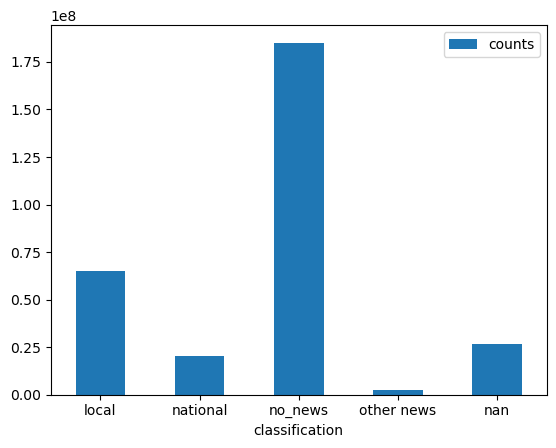

In [257]:
reclass.plot.bar(x='classification', y='counts', rot=0)

In [258]:
df_category_grouped_class.drop('label', axis=1, inplace=True)

In [259]:
df_category_grouped_class['counts'].sum()

299573378

In [260]:
df_category_grouped_class

,domain,serp_rank,is_home_district,category,counts,classification
0,1011now.com,2.0,False,news,2,local
1,1011now.com,3.0,False,news,13,local
2,1011now.com,4.0,False,news,1200,local
3,1011now.com,5.0,False,news,6503,local
4,1011now.com,5.0,True,news,18,local
...,...,...,...,...,...,...
94153,zoelofgren.com,21.0,False,campaign_personal,446,NaN
94154,zoelofgren.com,21.0,True,campaign_personal,1,NaN
94155,zoelofgren.com,22.0,False,campaign_personal,27,NaN
94156,zoelofgren.com,23.0,False,campaign_personal,435,NaN


In [261]:
df_category_grouped_class.to_csv("../data/house_analysis/domain_rank_ishome_category_counts.csv", index=False)